In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (9,6)

### Load dataset

In [2]:
from kagglehub import KaggleDatasetAdapter, load_dataset
df = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mashlyn/online-retail-ii-uci",
    "online_retail_II.csv"
)

/tmp/ipython-input-2-1001518671.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = load_dataset(


100%|██████████| 14.5M/14.5M [00:00<00:00, 66.8MB/s]

Extracting zip of online_retail_II.csv...


In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom




---

### Data Cleaning

In [4]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


Since we are focusing on the Customer lifetime value Customer ID is needed, so we are gonna remove rows without Customer ID.

In [5]:
df = df.dropna(subset=['Customer ID'])

Invoice starting with letter 'C' shows it is a cancelled order, let's remove such kind of orders.

In [6]:
df = df[~df['Invoice'].str.startswith('C')]

In [7]:
df['Quantity'].min()

1

In [8]:
df['Price'].min()

0.0

In [9]:
df.dtypes

,0
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
Price,float64
Customer ID,float64
Country,object


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Calculating Total amount of the order.

In [11]:
df['Total amount'] = df['Price'] * df['Quantity']

In [12]:
df['Customer ID'].nunique()

5881

There are 5881 unique customers.



---

### **Feature engineering**

In [13]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

We'll use last 90 days in dataset for CLV calculations and rest for feature creation.

In [14]:
from datetime import timedelta
cutoff_date = df['InvoiceDate'].max() - timedelta(days=90)
print(f"Feature period: {df['InvoiceDate'].min().date()} to {cutoff_date.date()}")
print(f"CLV calculation period: {cutoff_date.date()} to {df['InvoiceDate'].max()}")

Feature period: 2009-12-01 to 2011-09-10
CLV calculation period: 2011-09-10 to 2011-12-09 12:50:00


In [15]:
df_features = df[df['InvoiceDate'] <= cutoff_date]
df_clv = df[df['InvoiceDate'] > cutoff_date]
len(df_features), len(df_clv)

(644074, 161546)

In [16]:
customer_features = df_features.groupby('Customer ID').agg({
    'InvoiceDate' : ['min','max','count'],
    'Quantity' : ['sum','mean'],
    'Price' : ['mean','std'],
    'Invoice' : 'nunique',
    'StockCode' : 'nunique'
}).round(2)

In [17]:
customer_features.columns=[
    'first_purchase_date','last_purchase_date','total_orders',
    'total_quantity','avg_quatity_per_order','avg_unit_price','unit_price_std','unique_invoices','unique_products'
]

Some extra features

In [18]:
customer_features['customer_age_days'] = (cutoff_date - customer_features['first_purchase_date']).dt.days
customer_features['days_since_last_purchase'] = (cutoff_date - customer_features['last_purchase_date']).dt.days
epsilon = 1e-6 # small number to avoid division by zero
customer_features['purchase_frequency'] = customer_features['unique_invoices'] / ((customer_features['customer_age_days']/30)+epsilon)
customer_features['average_days_between_purchase'] = customer_features['customer_age_days'] / customer_features['unique_invoices']
customer_features['is_onetime_buyer'] = (customer_features['unique_invoices']==1).astype(int)
customer_features['product_diversity'] = customer_features['unique_products']/customer_features['unique_invoices']

If customer only had one purchase **unit_price_std** will be Nan , let's set that to 0.

In [19]:
customer_features['unit_price_std'] = customer_features['unit_price_std'].fillna(0)

Calculating target CLV

In [20]:
clv_data = df_clv.groupby('Customer ID')['Total amount'].sum().reset_index()
clv_data.columns = ['Customer ID', 'target_clv']

Merging calculated CLV to our features.

In [21]:
customer_data = customer_features.reset_index().merge(clv_data,on='Customer ID',how='inner')

In [22]:
customer_data.drop(columns=['first_purchase_date','last_purchase_date'],inplace=True)

In [23]:
customer_data['target_clv'].skew(), customer_data['target_clv'].kurtosis()

(np.float64(18.818268963822224), np.float64(421.04692537298405))

1.  skew = 18 and kurtosis = 421(very peaked distribution)
2.  most customers have low CLV, but a few have extremely high CLV.
3.  so, we can apply log transformation on **target_clv**

In [24]:
customer_data['target_clv'] = np.log1p(customer_data['target_clv'])

### EDA

Dataset overview

In [25]:
print(f"Total customers: {len(customer_data):,}")
print(f"Average CLV: £{customer_data['target_clv'].mean():.2f}")
print(f"Median CLV: £{customer_data['target_clv'].median():.2f}")
print(f"CLV Range: £{customer_data['target_clv'].min():.2f} - £{customer_data['target_clv'].max():.2f}")

Total customers: 2,292
Average CLV: £6.32
Median CLV: £6.28
CLV Range: £1.47 - £12.03


In [26]:
print(f"- One-time customers: {customer_data['is_onetime_buyer'].sum():,} ({customer_data['is_onetime_buyer'].mean()*100:.1f}%)")
print(f"- Average customer age: {customer_data['customer_age_days'].mean():.0f} days")
print(f"- Average purchase frequency: {customer_data['purchase_frequency'].mean():.2f} orders/month")



- One-time customers: 318 (13.9%)
- Average customer age: 441 days
- Average purchase frequency: 873.30 orders/month


In [27]:
top_customers = customer_data.nlargest(10,'target_clv')
print("\n Top 10 customers by CLV")
for i, row in top_customers.iterrows():
  print(f"- Customer {row['Customer ID']} : £{row['target_clv']:.2f} CLV, {row['unique_invoices']} orders, {row['unique_products']} products")


 Top 10 customers by CLV
- Customer 16446.0 : £12.03 CLV, 1.0 orders, 2.0 products
- Customer 18102.0 : £11.73 CLV, 112.0 orders, 311.0 products
- Customer 17450.0 : £11.59 CLV, 28.0 orders, 128.0 products
- Customer 14646.0 : £11.53 CLV, 121.0 orders, 806.0 products
- Customer 14096.0 : £11.08 CLV, 3.0 orders, 56.0 products
- Customer 14911.0 : £11.03 CLV, 309.0 orders, 2182.0 products
- Customer 16684.0 : £10.40 CLV, 45.0 orders, 156.0 products
- Customer 17511.0 : £10.36 CLV, 50.0 orders, 583.0 products
- Customer 16029.0 : £10.19 CLV, 96.0 orders, 56.0 products
- Customer 14088.0 : £10.13 CLV, 10.0 orders, 297.0 products


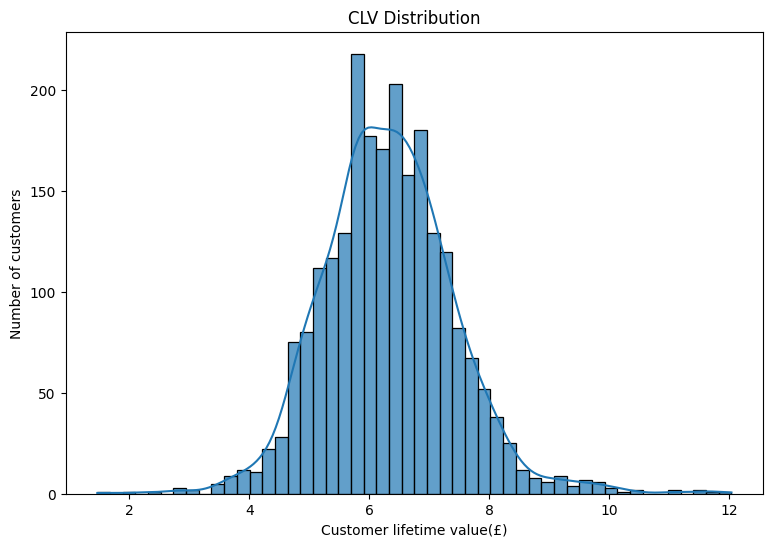

In [28]:
sns.histplot(customer_data['target_clv'],bins=50,alpha=0.7,kde=True)
plt.xlabel('Customer lifetime value(£)')
plt.ylabel('Number of customers')
plt.title('CLV Distribution')
plt.show()

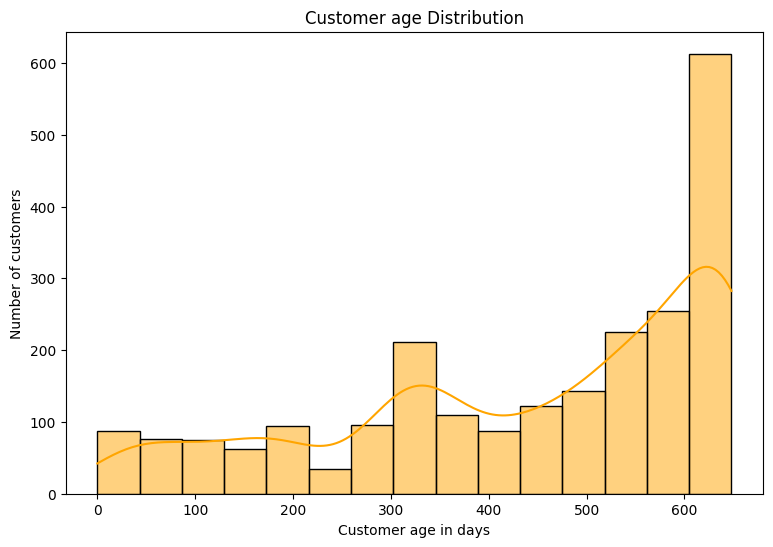

In [29]:
sns.histplot(customer_data['customer_age_days'],color='orange',kde=True)
plt.xlabel('Customer age in days')
plt.ylabel('Number of customers')
plt.title('Customer age Distribution')
plt.show()

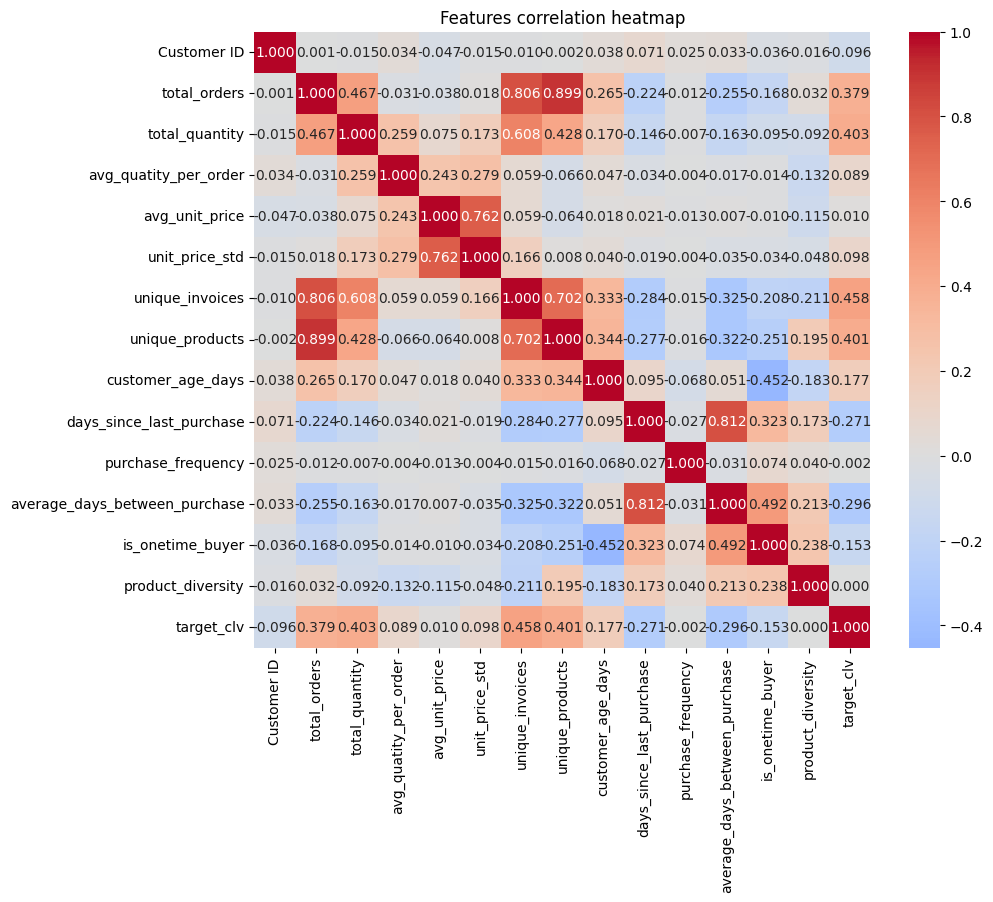

In [30]:
plt.figure(figsize=(10,8))
correlation_matrix = customer_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Features correlation heatmap')
plt.show()

1.  We can se that **unique_invoice, total_quantity, unique_products, days_since_last_purchase and average_days_between_purchase** are correlated with CLV.
2.  There are some multicollinearity to let's inspect them using **VIF**.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

features = [
    'total_orders', 'total_quantity', 'avg_quatity_per_order', 'avg_unit_price',
    'unit_price_std', 'unique_invoices', 'unique_products', 'customer_age_days',
    'days_since_last_purchase', 'purchase_frequency',
    'average_days_between_purchase', 'is_onetime_buyer', 'product_diversity'
]
X = customer_data[features].copy()
x_const = add_constant(X)

vif = pd.DataFrame()
vif['features'] = x_const.columns
vif['vif'] = [variance_inflation_factor(x_const.values,i) for i in range(x_const.shape[1])]
vif = vif[vif['features'] != 'const']
vif.sort_values('vif',ascending=False)


,features,vif
1,total_orders,9.358636
7,unique_products,8.822790
6,unique_invoices,4.813205
11,average_days_between_purchase,4.170396
9,days_since_last_purchase,3.044262
5,unit_price_std,2.644097
4,avg_unit_price,2.485399
8,customer_age_days,2.071056
12,is_onetime_buyer,2.015913
13,product_diversity,1.798232




1.   So, let's remove **total_orders and unique_products** because these are possibly inflate our results due to high multicollinearity.
2.   And also **avg_unit_price, product_diversity and purchase_frequency** need to be removed because these have no impact on CLV.



In [32]:
customer_data.drop(columns=['purchase_frequency','product_diversity','avg_unit_price','unique_products','total_orders'],inplace=True)



---

Data preparation

In [33]:
X = customer_data.drop(columns=['Customer ID','target_clv'])
y = customer_data['target_clv']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)


### Model training

In [34]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

Evaluate model

In [35]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))

print(f"- R²: {r2:.3f} (explains {r2*100:.1f}% of variance)")
print(f"- MSE: {mse:.3f}")
print(f"- RMSE: £{rmse:.2f}")
print(f"- MAE: £{mae:.2f}")
print(f"- Train vs Test RMSE: £{train_rmse:.2f} vs £{rmse:.2f}")


- R²: 0.236 (explains 23.6% of variance)
- MSE: 0.813
- RMSE: £0.90
- MAE: £0.71
- Train vs Test RMSE: £0.95 vs £0.90


In [36]:
#actual vs predicted clv mean

print(f"actual mean: {y_test.mean()} VS Predicted mean: {y_pred.mean()}")

actual mean: 6.34949493773221 VS Predicted mean: 6.285446345180576


This mean the model if highly accurate on average but the Individual predictions are off (which we saw with R² = 0.236) or model struggles on extreme(low/high) CLV values.

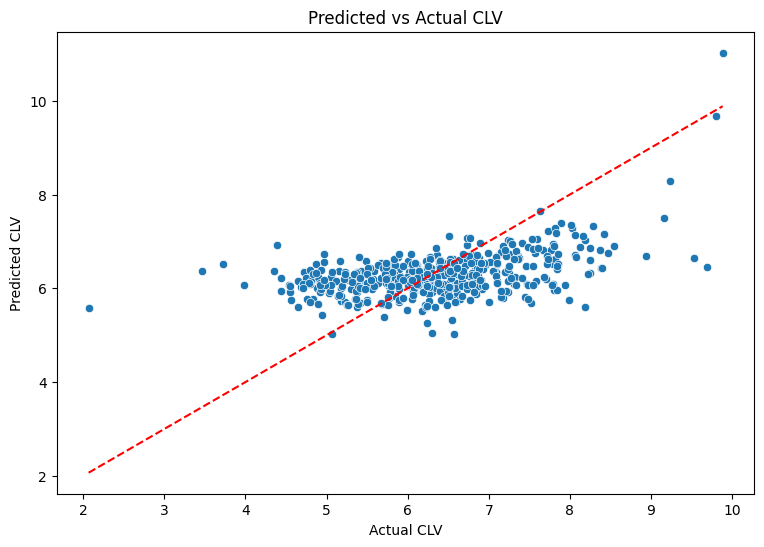

In [38]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Predicted vs Actual CLV")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


Feature importance

In [39]:
feature_importance = pd.DataFrame({
    'features' : X_train.columns,
    'coefficient' : model.coef_
}).sort_values('coefficient',ascending=False)
feature_importance

,features,coefficient
3,unique_invoices,0.251037
0,total_quantity,0.234862
4,customer_age_days,0.129774
7,is_onetime_buyer,0.089414
2,unit_price_std,0.023448
1,avg_quatity_per_order,-0.004403
5,days_since_last_purchase,-0.085940
6,average_days_between_purchase,-0.199893


### Visualization assumptions

Residuals plot

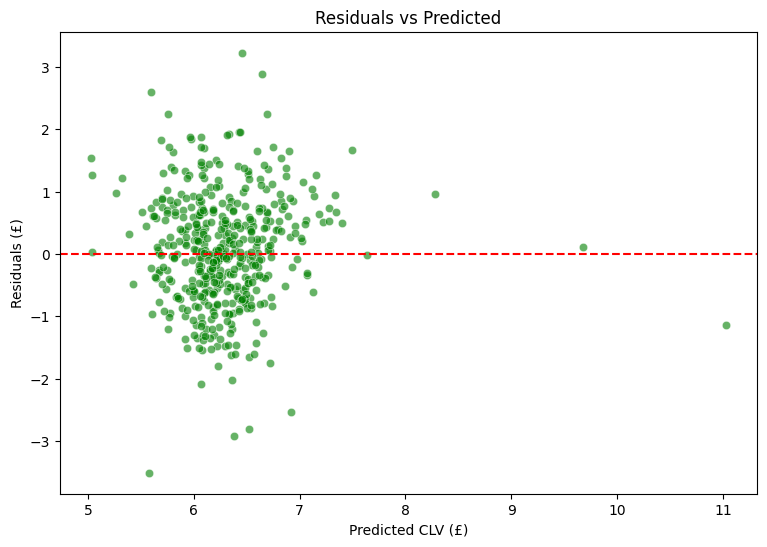

In [43]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred,y=residuals,alpha=0.6,color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted CLV (£)')
plt.ylabel('Residuals (£)')
plt.title('Residuals vs Predicted')
plt.show()


Residuals are randomly scattered around 0, so no problem.



---

Residuals histogram

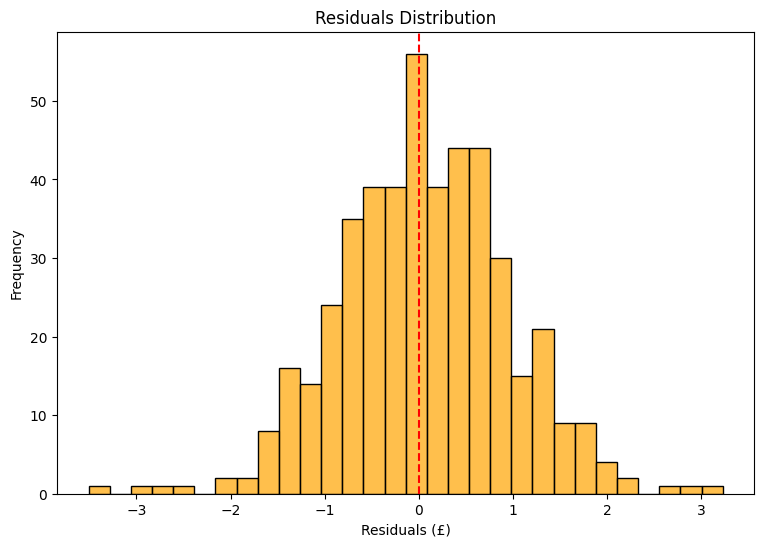

In [47]:

sns.histplot(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals (£)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


Residuals are normally distributed

### Conclusion

While linear regression offers a strong starting point and interpretable results, CLV prediction is inherently nonlinear(Highly skewed). Future improvements could include non-linear models (e.g., XGBoost) and segmentation strategies to better capture extreme customer behaviors.